<a href="https://colab.research.google.com/github/nsanghi/pyprobml/blob/pr_gnn_806/notebooks/book1/23/gnn_node_classification_jraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN Node Classification

### Author: Nimish Sanghi https://github.com/nsanghi

In this notebook we will use [JAX](https://github.com/google/jax), [Haiku](https://dm-haiku.readthedocs.io/en/latest/), [Optax](https://optax.readthedocs.io/en/latest/) and [Jraph](https://jraph.readthedocs.io/en/latest/)


**JAX** is a numerical computing library that combines NumPy, automatic differentiation, and first-class GPU/TPU support.

**Haiku** is a simple neural network library for JAX that enables users to use familiar object-oriented programming models while allowing full access to JAX's pure function transformations.

**Optax** is a gradient processing and optimization library for JAX.

**Jraph** (pronounced “giraffe”) is a lightweight library for working with graph neural networks in jax. It provides a data structure for graphs, a set of utilites for working with graphs, and a ‘zoo’ of forkable graph neural network models.

We will use Graph Convolution layer [jraph.GraphConvolution](https://jraph.readthedocs.io/en/latest/api.html#jraph.GraphConvolution) on a simple grpah to classify the nodes of the grpahs. We also see how accuracy of graph can be improved by replacing Convolution layer with Graph Attention Network layer [jraph.GAT](https://jraph.readthedocs.io/en/latest/api.html#jraph.GAT)

This notebook is based on:
https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb

## Setup: Install and Import libraries

In [1]:
# Imports
%matplotlib inline
from typing import Any, Callable, Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree

try:
    import jraph
except ModuleNotFoundError:
    %pip install -qq -U git+https://github.com/deepmind/jraph.git
    import jraph

try:
    import haiku as hk
except ModuleNotFoundError:
    %pip install -qq -U dm-haiku
    import haiku as hk

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq -U optax
    import optax

try:
    import networkx as nx
except ModuleNotFoundError:
    %pip install -qq -U networkx
    import networkx as nx

     |████████████████████████████████| 309 kB 4.8 MB/s 
     |████████████████████████████████| 140 kB 4.9 MB/s 
     |████████████████████████████████| 72 kB 812 kB/s 


## Representing a Graph in jraph

In jraph, a graph is represented with a `GraphsTuple` object. In addition to defining the graph structure of nodes and edges, you can also store node features, edge features and global graph features in a `GraphsTuple`.

In the `GraphsTuple`, edges are represented in two aligned arrays of node indices: senders (source nodes) and receivers (destinaton nodes).
Each index corresponds to one edge, e.g. edge `i` goes from `senders[i]` to `receivers[i]`.

#### Visualizing the Graph
To visualize the graph structure, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

In [2]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
    nodes, edges, receivers, senders, _, _, _ = jraph_graph
    nx_graph = nx.DiGraph()
    if nodes is None:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n)
    else:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n, node_feature=nodes[n])
    if edges is None:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]), int(receivers[e]))
    else:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]), int(receivers[e]), edge_feature=edges[e])
    return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
    nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color="yellow")

#### Zachary's Karate Club Dataset

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a small dataset commonly used as an example for a social graph. It's great for demo purposes, as it's easy to visualize and quick to train a model on it.

A node represents a student or instructor in the club. An edge means that those two people have interacted outside of the class. There are two instructors in the club.

Each student is assigned to one of two instructors.

#### Optimizing the GCN on the Karate Club Node Classification Task

The task is to predict the assignment of students to instructors, given the social graph and only knowing the assignment of two nodes (the two instructors) a priori.

In other words, out of the 34 nodes, only two nodes are labeled, and we are trying to optimize the assignment of the other 32 nodes, by **maximizing the log-likelihood of the two known node assignments**.

We will compute the accuracy of our node assignments by comparing to the ground-truth assignments. **Note that the ground-truth for the 32 student nodes is not used in the loss function itself.**

In [3]:
"""Zachary's karate club example.
From https://github.com/deepmind/jraph/blob/master/jraph/examples/zacharys_karate_club.py.
Here we train a graph neural network to process Zachary's karate club.
https://en.wikipedia.org/wiki/Zachary%27s_karate_club
Zachary's karate club is used in the literature as an example of a social graph.
Here we use a graphnet to optimize the assignments of the students in the
karate club to two distinct karate instructors (Mr. Hi and John A).
"""


def get_zacharys_karate_club() -> jraph.GraphsTuple:
    """Returns GraphsTuple representing Zachary's karate club."""
    social_graph = [
        (1, 0),
        (2, 0),
        (2, 1),
        (3, 0),
        (3, 1),
        (3, 2),
        (4, 0),
        (5, 0),
        (6, 0),
        (6, 4),
        (6, 5),
        (7, 0),
        (7, 1),
        (7, 2),
        (7, 3),
        (8, 0),
        (8, 2),
        (9, 2),
        (10, 0),
        (10, 4),
        (10, 5),
        (11, 0),
        (12, 0),
        (12, 3),
        (13, 0),
        (13, 1),
        (13, 2),
        (13, 3),
        (16, 5),
        (16, 6),
        (17, 0),
        (17, 1),
        (19, 0),
        (19, 1),
        (21, 0),
        (21, 1),
        (25, 23),
        (25, 24),
        (27, 2),
        (27, 23),
        (27, 24),
        (28, 2),
        (29, 23),
        (29, 26),
        (30, 1),
        (30, 8),
        (31, 0),
        (31, 24),
        (31, 25),
        (31, 28),
        (32, 2),
        (32, 8),
        (32, 14),
        (32, 15),
        (32, 18),
        (32, 20),
        (32, 22),
        (32, 23),
        (32, 29),
        (32, 30),
        (32, 31),
        (33, 8),
        (33, 9),
        (33, 13),
        (33, 14),
        (33, 15),
        (33, 18),
        (33, 19),
        (33, 20),
        (33, 22),
        (33, 23),
        (33, 26),
        (33, 27),
        (33, 28),
        (33, 29),
        (33, 30),
        (33, 31),
        (33, 32),
    ]
    # Add reverse edges.
    social_graph += [(edge[1], edge[0]) for edge in social_graph]
    n_club_members = 34

    return jraph.GraphsTuple(
        n_node=jnp.asarray([n_club_members]),
        n_edge=jnp.asarray([len(social_graph)]),
        # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
        nodes=jnp.eye(n_club_members),
        # No edge features.
        edges=None,
        globals=None,
        senders=jnp.asarray([edge[0] for edge in social_graph]),
        receivers=jnp.asarray([edge[1] for edge in social_graph]),
    )


def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
    """Returns ground truth assignments for Zachary's karate club."""
    return jnp.array(
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    )

In [4]:
graph = get_zacharys_karate_club()

Visualize the karate club graph with circular node layout:

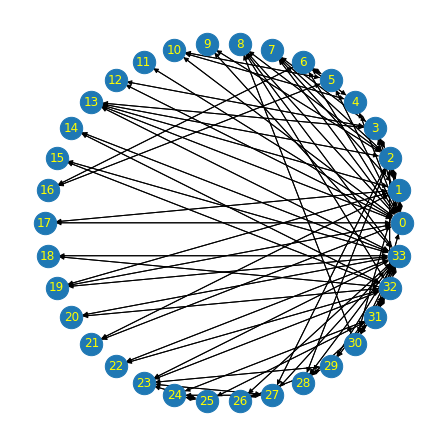

In [5]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color="yellow")

## Node Classification with GCN

Define the GCN with the `jraph.GraphConvolution` layer. We will use two convolution layers.

`jraph.GraphConvolution` requires following parameters:

- `update_node_fn` - function used to update the nodes. We will use a single layer MLP with ReLU

- `aggregate_nodes_fn` - function used to aggregates the sender nodes. The default is [jax.ops.segment_sum](https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.segment_sum.html), i.e. to sum the node features of the neighbors. We will use the default value.

- `add_self_edges`- whether to add self edges to nodes in the graph. Defaults to `False`. We will set this value of `True`.

- `symmetric_normalization`- whether to use symmetric normalization. Defaults to True.

In [6]:
def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a GCN for the karate club task.
    Args:
      graph: GraphsTuple the network processes.

    Returns:
      output graph with updated node values.
    """
    gn = jraph.GraphConvolution(update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)), add_self_edges=True)
    graph = gn(graph)

    gn = jraph.GraphConvolution(update_node_fn=hk.Linear(2))  # output dim is 2 because we have 2 output classes.
    graph = gn(graph)
    return graph

Training and Evaluation code:

In [7]:
def optimize_club(network: hk.Transformed, num_steps: int) -> jnp.ndarray:
    """Solves the karate club problem by optimizing the assignments of students."""
    zacharys_karate_club = get_zacharys_karate_club()
    labels = get_ground_truth_assignments_for_zacharys_karate_club()
    params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

    @jax.jit
    def predict(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, zacharys_karate_club)
        return jnp.argmax(decoded_graph.nodes, axis=1)

    @jax.jit
    def prediction_loss(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, zacharys_karate_club)
        # We interpret the decoded nodes as a pair of logits for each node.
        log_prob = jax.nn.log_softmax(decoded_graph.nodes)
        # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
        # and John A (Node 33).
        return -(log_prob[0, 0] + log_prob[33, 1])

    opt_init, opt_update = optax.adam(1e-2)
    opt_state = opt_init(params)

    @jax.jit
    def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
        """Returns updated params and state."""
        g = jax.grad(prediction_loss)(params)
        updates, opt_state = opt_update(g, opt_state)
        return optax.apply_updates(params, updates), opt_state

    @jax.jit
    def accuracy(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, zacharys_karate_club)
        return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

    for step in range(num_steps):
        print(f"step {step} accuracy {accuracy(params).item():.2f}")
        params, opt_state = update(params, opt_state)

    return predict(params)

Let's train the GCN and check the accuracy. We expect this model to reach an accuracy of about 0.91.

In [8]:
network = hk.without_apply_rng(hk.transform(gcn_definition))
result = optimize_club(network, num_steps=15)

step 0 accuracy 0.06
step 1 accuracy 0.15
step 2 accuracy 0.35
step 3 accuracy 0.50
step 4 accuracy 0.59
step 5 accuracy 0.68
step 6 accuracy 0.71
step 7 accuracy 0.74
step 8 accuracy 0.74
step 9 accuracy 0.76
step 10 accuracy 0.76
step 11 accuracy 0.91
step 12 accuracy 0.91
step 13 accuracy 0.91
step 14 accuracy 0.91


Visualize ground truth and predicted node assignments:

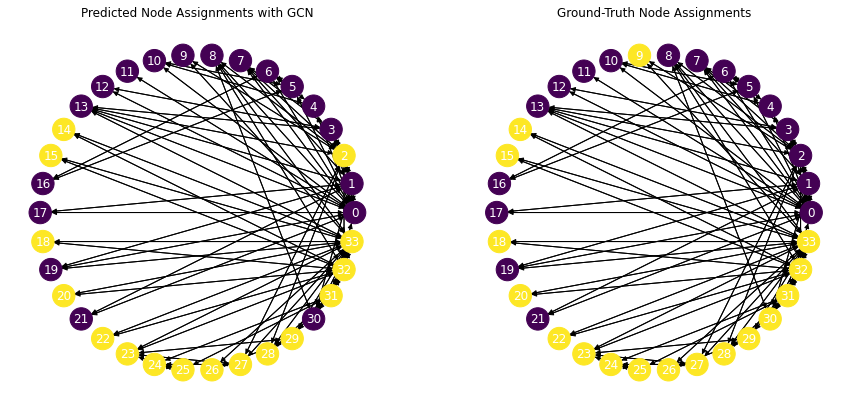

In [9]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, node_color=result.tolist(), font_color="white")
ax1.title.set_text("Predicted Node Assignments with GCN")

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, node_color=gt_labels.tolist(), font_color="white")
ax2.title.set_text("Ground-Truth Node Assignments")
plt.show()

## Node Classification with Graph Attention (GAT) layer

While the GCN can learn meaningful representations, it also has some shortcomings.

In the GCN layer, the messages from all its neighbours and the node itself are equally weighted. This may lead to loss of node-specific information. E.g., consider the case when a set of nodes shares the same set of neighbors, and start out with different node features. Then because of averaging, their resulting output features would be the same. Adding self-edges mitigates this issue by a small amount, but this problem is magnified with increasing number of GCN layers and number of edges connecting to a node.

The graph attention (GAT) mechanism, as proposed by [Velickovic et al. ( 2017)](https://arxiv.org/abs/1710.10903), allows the network to learn how to weigh / assign importance to the node features from the neighbourhood when computing the new node features. This is very similar to the idea of using attention in Transformers, which were introduced in [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762).

(One could even argue that Transformers are graph attention networks operating on the special case of fully-connected graphs.)

In the figure below, $\vec{h}$ are the node features and $\vec{\alpha}$ are the learned attention weights.



<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/gat1.png" width="400px">

Figure Credit: [Velickovic et al. ( 2017)](https://arxiv.org/abs/1710.10903).
(Detail: This image is showing multi-headed attention with 3 heads, each color corresponding to a different head. At the end, an aggregation function is applied over all the heads.)

To obtain the output node features of the GAT layer, we compute:

$$ \vec{h}'_i = \sum _{j \in \mathcal{N}(i)}\alpha_{ij} \mathbf{W} \vec{h}_j$$
Here, $\mathbf{W}$ is a weight matrix which performs a linear transformation on the input.


We will use `jraph.GAT(attention_query_fn, attention_logit_fn, node_update_fn=None)` to build the Graph Attention Network. 

`attention_query_fn` - function that generates attention queries from sender node features.

`attention_logit_fn` - function that converts attention queries into logits for softmax attention.

`node_update_fn` - function that updates the aggregated messages. If None, will apply leaky relu and concatenate (if using multi-head attention).

`jraph.GAT` assumes that graph as self-edges as part of the grpah provided to GAT. We need to add `self-edges` ourselves

In [10]:
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a GAT network for the karate club node classification task.

    Args:
      graph: GraphsTuple the network processes.

    Returns:
      output graph with updated node values.
    """

    def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray, edges: jnp.ndarray) -> jnp.ndarray:
        del edges
        x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
        return hk.Linear(1)(x)

    def _add_self_edges_fn(
        receivers: jnp.ndarray, senders: jnp.ndarray, total_num_nodes: int
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """Adds self edges. Assumes self edges are not in the graph yet."""
        receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
        senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
        return receivers, senders

    # deconstruct graph
    nodes, edges, receivers, senders, _, _, _ = graph

    # add self edges
    # We add self edges to the senders and receivers so that each node
    # includes itself in aggregation.
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    receivers, senders = _add_self_edges_fn(receivers, senders, total_num_nodes)

    # update graph with self edges
    graph = jraph.GraphsTuple(
        n_node=graph.n_node,
        n_edge=graph.n_edge + total_num_nodes,
        # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
        nodes=graph.nodes,
        # No edge features.
        edges=None,
        globals=None,
        senders=senders,
        receivers=receivers,
    )

    gn = jraph.GAT(
        attention_query_fn=lambda n: hk.Linear(8)(n), attention_logit_fn=_attention_logit_fn, node_update_fn=None
    )
    graph = gn(graph)

    gn = jraph.GAT(
        attention_query_fn=lambda n: hk.Linear(8)(n),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Linear(2),
    )
    graph = gn(graph)
    return graph

Let's train the model. We expect the model to reach an accuracy of about 0.97.

In [11]:
network = hk.without_apply_rng(hk.transform(gat_definition))
result = optimize_club(network, num_steps=15)

step 0 accuracy 0.50
step 1 accuracy 0.94
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 0.97
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 0.97
step 14 accuracy 0.97


Visualize ground truth and predicted node assignments:

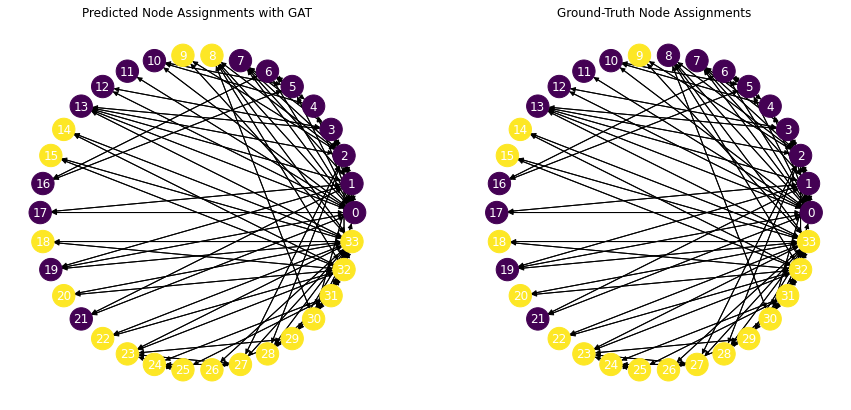

In [12]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, node_color=result.tolist(), font_color="white")
ax1.title.set_text("Predicted Node Assignments with GAT")

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, node_color=gt_labels.tolist(), font_color="white")
ax2.title.set_text("Ground-Truth Node Assignments")
plt.show()